Cluster Centers (Year, Duration):
[[1988.49820008  119.26161062]
 [2015.09534439  116.38454084]
 [2016.45300004   78.07962421]]


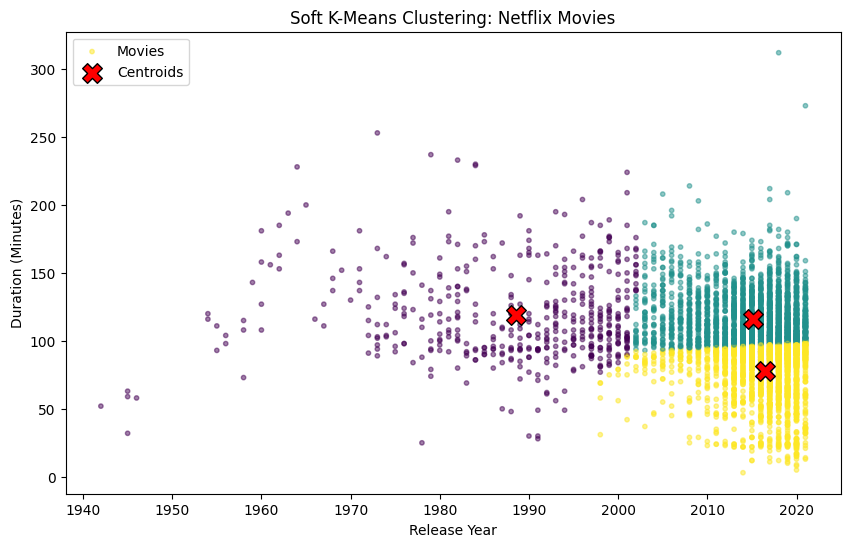

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- 1. Data Preparation ---
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Datasets/netflix_data.csv')

# Filter for Movies and extract numeric duration
df_movies = df[df['type'] == 'Movie'].copy()
df_movies['duration_min'] = df_movies['duration'].str.replace(' min', '').astype(float)

# Drop missing values
df_movies = df_movies.dropna(subset=['duration_min', 'release_year'])

# Select features: Year and Duration
features = df_movies[['release_year', 'duration_min']].values

# Standardize the data (Important for K-Means to work correctly)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# --- 2. Soft K-Means Algorithm Implementation ---
def soft_kmeans(X, K, max_iters=100, beta=2.0):
    """
    X: Data (n_samples, n_features)
    K: Number of clusters
    beta: Stiffness parameter (Higher = Harder clustering, Lower = Softer)
    """
    n_samples, n_features = X.shape

    # Step 1: Initialize Centroids randomly
    random_indices = np.random.choice(n_samples, K, replace=False)
    centroids = X[random_indices]

    responsibilities = np.zeros((n_samples, K))

    for i in range(max_iters):
        # Step 2: Expectation (Calculate Soft Assignments)
        # Calculate squared Euclidean distance from every point to every centroid
        distances = np.zeros((n_samples, K))
        for k in range(K):
            distances[:, k] = np.sum((X - centroids[k])**2, axis=1)

        # Apply Softmax to distances to get probabilities
        # We subtract min(distances) for numerical stability with exp()
        distances_stable = distances - np.min(distances, axis=1, keepdims=True)
        exp_terms = np.exp(-beta * distances_stable)
        responsibilities = exp_terms / np.sum(exp_terms, axis=1, keepdims=True)

        # Step 3: Maximization (Update Centroids)
        old_centroids = centroids.copy()
        for k in range(K):
            # Weighted average of all points
            weight_sum = np.sum(responsibilities[:, k])
            if weight_sum > 0:
                centroids[k] = np.sum(responsibilities[:, k].reshape(-1, 1) * X, axis=0) / weight_sum

        # Step 4: Check for Convergence
        if np.allclose(centroids, old_centroids, rtol=1e-4):
            break

    return centroids, responsibilities

# --- 3. Run the Model ---
K_clusters = 3
centroids_scaled, responsibilities = soft_kmeans(X_scaled, K=K_clusters, beta=3.0)

# Inverse transform centroids to see the actual Year and Minutes
centroids_original = scaler.inverse_transform(centroids_scaled)

print("Cluster Centers (Year, Duration):")
print(centroids_original)

# --- 4. Visualization ---
plt.figure(figsize=(10, 6))

# Color points by their strongest cluster assignment
hard_labels = np.argmax(responsibilities, axis=1)

plt.scatter(features[:, 0], features[:, 1], c=hard_labels, cmap='viridis', s=10, alpha=0.5, label='Movies')
plt.scatter(centroids_original[:, 0], centroids_original[:, 1], c='red', s=200, marker='X', edgecolors='black', label='Centroids')

plt.title('Soft K-Means Clustering: Netflix Movies')
plt.xlabel('Release Year')
plt.ylabel('Duration (Minutes)')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
